In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('APPRAISE_NETFLOW.csv').dropna()
print(df.head())

   FLOW_ID   IPV4_SRC_ADDR   IPV4_DST_ADDR  IN_PKTS  IN_BYTES  OUT_PKTS  \
0        1  89.159.255.164     5.9.222.138      604     27180       614   
1        2    189.5.173.17   80.19.141.188      506     23082       510   
2        3  80.158.159.207  86.190.158.122       24      1704         0   
3        4   102.81.138.56    135.44.76.80      284     23034       284   
4        5    96.41.79.140     62.185.7.85        4       160         2   

   OUT_BYTES  FIRST_SWITCHED  LAST_SWITCHED  L4_SRC_PORT  L4_DST_PORT  \
0      29994      1674045983   1.674046e+09      47808.0      47808.0   
1      23424      1674045983   1.674046e+09        502.0       4872.0   
2          0      1674045983   1.674046e+09      47808.0      47808.0   
3      26004      1674045983   1.674046e+09      61765.0      51807.0   
4        144      1674045983   1.674046e+09      50264.0       3028.0   

   TCP_FLAGS  PROTOCOL PROTOCOL_MAP  TOTAL_FLOWS_EXP  L7_PROTO L7_PROTO_NAME  \
0        0.0      17.0        

In [3]:
def change_fourth_octet(ip_source):
    parts = ip_source.split('.')
    parts[3] = '0'
    return '.'.join(parts)

df['IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].apply(change_fourth_octet)

# print(df.head())

In [4]:

def ip_to_float(ip):
    a, b, c, d = map(int, ip.split('.'))
    return (a << 24) + (b << 16) + (c << 8) + d
df['IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].apply(ip_to_float)
df['IPV4_DST_ADDR'] = df['IPV4_DST_ADDR'].apply(ip_to_float)

# print(df.head())

In [5]:
count_1 = df['ANOMALY_CATEGORY'].value_counts()
count_2 = df['ANOMALY'].value_counts()
# print(count_1, count_2)

In [6]:
mapping = {
    '-' : 0.0,
    'Reconnaissance': 1.0,
    'BruteForce' : 2.0
}

df['ANOMALY_CLASS'] = df['ANOMALY_CATEGORY'].map(mapping)

# print(df.head())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7780805 entries, 0 to 7780804
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   FLOW_ID           int64  
 1   IPV4_SRC_ADDR     int64  
 2   IPV4_DST_ADDR     int64  
 3   IN_PKTS           int64  
 4   IN_BYTES          int64  
 5   OUT_PKTS          int64  
 6   OUT_BYTES         int64  
 7   FIRST_SWITCHED    int64  
 8   LAST_SWITCHED     float64
 9   L4_SRC_PORT       float64
 10  L4_DST_PORT       float64
 11  TCP_FLAGS         float64
 12  PROTOCOL          float64
 13  PROTOCOL_MAP      object 
 14  TOTAL_FLOWS_EXP   float64
 15  L7_PROTO          float64
 16  L7_PROTO_NAME     object 
 17  ANOMALY_CATEGORY  object 
 18  ANOMALY           float64
 19  ANOMALY_CLASS     float64
dtypes: float64(9), int64(8), object(3)
memory usage: 1.2+ GB
None


In [7]:
unique = df['ANOMALY_CLASS'].nunique()
print(unique)
target = df['ANOMALY_CLASS']

3


In [8]:
le = LabelEncoder()
df['PROTOCOL_MAP'] = le.fit_transform(df['PROTOCOL_MAP'])
df['L7_PROTO_NAME'] = le.fit_transform(df['L7_PROTO_NAME'])

# print(df.info())

In [9]:
# Features all numeric columns, excluding ANOMALY columns
X = df.drop(columns=[col for col in df.columns if col.startswith('ANOMALY')])

print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7780805 entries, 0 to 7780804
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   FLOW_ID          int64  
 1   IPV4_SRC_ADDR    int64  
 2   IPV4_DST_ADDR    int64  
 3   IN_PKTS          int64  
 4   IN_BYTES         int64  
 5   OUT_PKTS         int64  
 6   OUT_BYTES        int64  
 7   FIRST_SWITCHED   int64  
 8   LAST_SWITCHED    float64
 9   L4_SRC_PORT      float64
 10  L4_DST_PORT      float64
 11  TCP_FLAGS        float64
 12  PROTOCOL         float64
 13  PROTOCOL_MAP     int64  
 14  TOTAL_FLOWS_EXP  float64
 15  L7_PROTO         float64
 16  L7_PROTO_NAME    int64  
dtypes: float64(7), int64(10)
memory usage: 1.0 GB
None


In [10]:
# X_train	Features for training	    Model learns patterns here
# y_train	Target labels for training	Model learns patterns here
# X_test	Features for testing	    Model makes predictions
# y_test	Target labels for testing	Evaluate accuracy/metrics

split_result = train_test_split(X, target, test_size=0.1, random_state=42, stratify=target)
X_train = split_result[0]
X_test  = split_result[1]
y_train = split_result[2]
y_test  = split_result[3]

In [11]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

In [12]:
print(y_test.value_counts())

ANOMALY_CLASS
0.0    563989
1.0    214073
2.0        19
Name: count, dtype: int64


In [13]:
model.fit(X_train, y_train)  # learns patterns from 80k rows
y_pred = model.predict(X_test)  # predicts on unseen 20k rows

accuracy = accuracy_score(y_test, y_pred)
# 100% accuracy (can be wrong, because data is skewed)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [15]:
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (binary):", f1)

F1 Score (binary): 0.9999845775529064


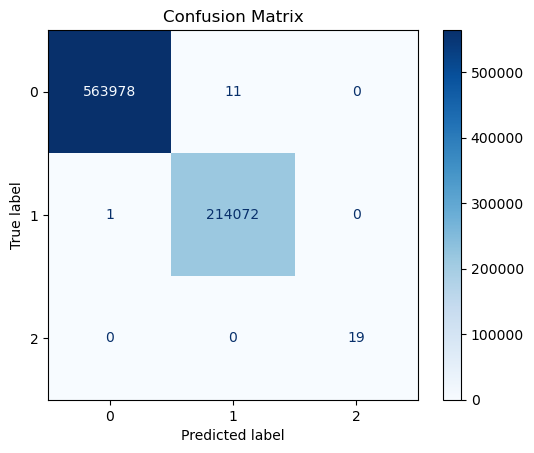

In [25]:
# visualize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [26]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))
print(np.unique(np.round(y_scores, 3)))


{0.0: 563989, 1.0: 214073, 2.0: 19}


NameError: name 'y_scores' is not defined

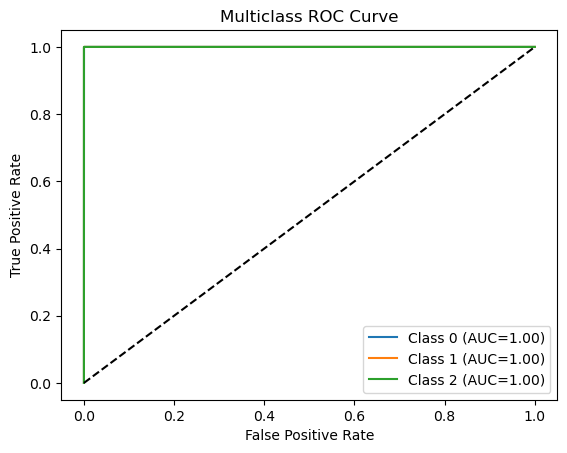

In [27]:
# Receiver Operating Characteristic (ROC) graph

# Binarize y_test
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities for each class
y_scores = model.predict_proba(X_test) 

# Plot ROC for each class
for i, c in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_scores[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f'Class {c} (AUC={auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.show()

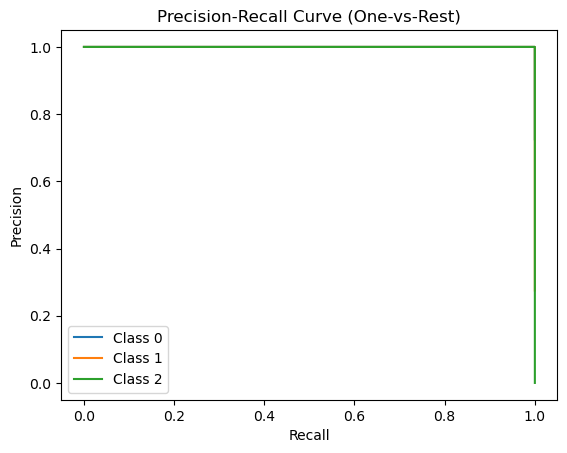

In [28]:
for i, class_label in enumerate(classes):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, label=f'Class {class_label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend()
plt.show()

In [36]:
print(y_test_bin)
print(y_scores)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[9.9995768e-01 2.4851799e-05 1.7428240e-05]
 [9.9988186e-01 9.6803138e-05 2.1348727e-05]
 [9.9997163e-01 1.6099861e-05 1.2289020e-05]
 ...
 [9.9997163e-01 1.6099861e-05 1.2289020e-05]
 [9.9997163e-01 1.6099861e-05 1.2289020e-05]
 [9.9997449e-01 1.3888969e-05 1.1575388e-05]]


In [37]:
y_train_pred = model.predict_proba(X_train)
y_test_pred  = model.predict_proba(X_test)

train_auc = roc_auc_score(label_binarize(y_train, classes=[0,1,2]), y_train_pred)
test_auc  = roc_auc_score(label_binarize(y_test, classes=[0,1,2]), y_test_pred)
print(train_auc, test_auc)

0.9999999952490949 0.9999999992021588


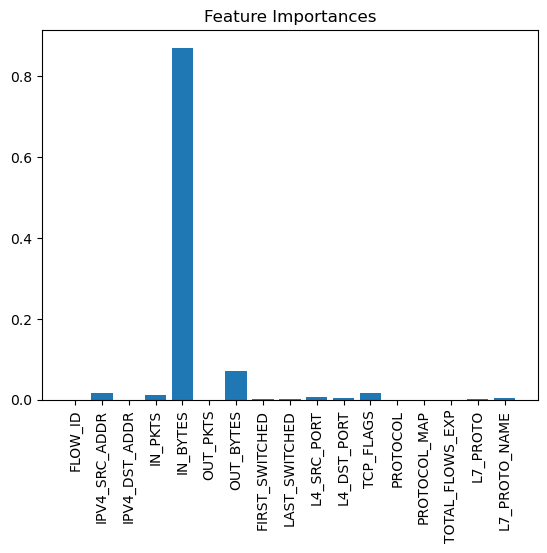

In [74]:
# Feature Importance
import matplotlib.pyplot as plt

importances = model.feature_importances_
plt.bar(X.columns, importances)
plt.xticks(rotation=90)
plt.title("Feature Importances")
plt.show()

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


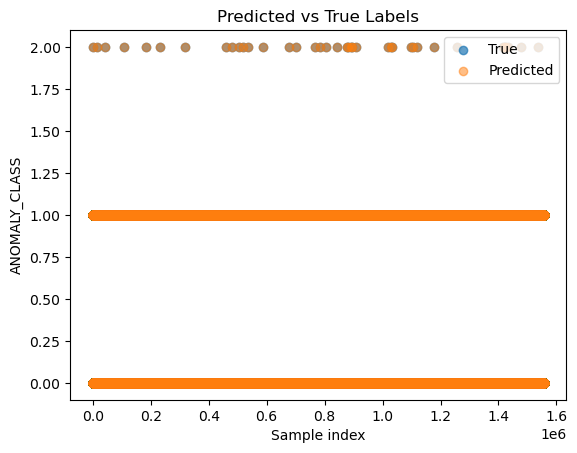

In [75]:
# Predicted vs True Labels (Scatter/Strip Plot)

plt.scatter(range(len(y_test)), y_test, label='True', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred, label='Predicted', alpha=0.5)
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("ANOMALY_CLASS")
plt.title("Predicted vs True Labels")
plt.show()

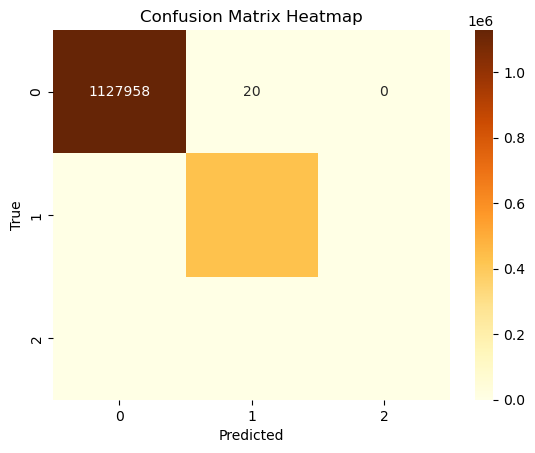

In [79]:
# Heatmap of Confusion Matrix

import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d", xticklabels=model.classes_, yticklabels=model.classes_, cmap="YlOrBr")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()